In [1]:
import pyabc
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
import scipy as sp
import time

%matplotlib inline

db_path = ("sqlite://")
logfile_path="/home/felipe/testresults/MJPAcceptanceRates.csv"

In [2]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost",
                                                       port=6379,
                                                       look_ahead = True)

eps=pyabc.MedianEpsilon(500, median_multiplier=0.8)

max_nr_pop=10
min_eps=0.8
pop_size = 200
iters=100

In [3]:
def h(x, pre, c):
    return (x**pre).prod(1) * c

def gillespie(x, c, pre, post, max_t):
    """
    Gillespie simulation
    
    Parameters
    ----------
    
    x: 1D array of size n_species
        The initial numbers.
    
    c: 1D array of size n_reactions
        The reaction rates.
    
    pre: array of size n_reactions x n_species
        What is to be consumed.
    
    post: array of size n_reactions x n_species
        What is to be produced
    
    max_t: int
        Timulate up to time max_t
        
    Returns
    -------
    t, X: 1d array, 2d array
        t: The time points.
        X: The history of the species.
           ``X.shape == (t.size, x.size)``
    
    """
    t = 0
    t_store = [t]
    x_store = [x.copy()]
    S = post - pre

    while t < max_t:
        h_vec = h(x, pre, c)
        h0 = h_vec.sum()
        if h0 == 0:
            break
        delta_t = np.random.exponential(1 / h0)
        # no reaction can occur any more
        if not np.isfinite(delta_t):
            t_store.append(max_t)
            x_store.append(x)
            break
        reaction = np.random.choice(c.size, p=h_vec/h0)
        t = t + delta_t
        x = x + S[reaction]
        
        t_store.append(t)
        x_store.append(x)

    return np.array(t_store), np.array(x_store)

In [4]:
MAX_T = 0.1

class Model1:
    __name__ = "Model 1"
    x0 = np.array([40, 3])   # Initial molecule numbers
    pre = np.array([[1, 1]], dtype=int)
    post = np.array([[0, 2]])
    
    
    def __call__(self, par):
        t, X = gillespie(self.x0,
                         np.array([float(par["rate"])]),
                         self.pre, self.post,
                         MAX_T)
        return {"t": t, "X" : X}
    
    
true_rate = 2.3
observations = Model1()({"rate": true_rate})

N_TEST_TIMES = 20

t_test_times = np.linspace(0, MAX_T, N_TEST_TIMES)

def distance(x, y):
    xt_ind = np.searchsorted(x["t"], t_test_times) - 1
    yt_ind = np.searchsorted(y["t"], t_test_times) - 1
    error = (np.absolute(x["X"][:,1][xt_ind]
                        - y["X"][:,1][yt_ind]).sum()
             / t_test_times.size)
    return error

prior = pyabc.Distribution(rate=pyabc.RV("uniform", 0, 100))

INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 00:52:08.350602, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Preliminary acceptance rate: 29 / 441 = 6.5760e-02
INFO:ABC:Acceptance rate: 200 / 3035 = 6.5898e-02, ESS=1.9815e+02.
INFO:ABC:t: 2, eps: 5.04.
INFO:ABC:Preliminary acceptance rate: 118 / 382 = 3.0890e-01
INFO:ABC:Acceptance rate: 200 / 645 = 3.1008e-01, ESS=1.9644e+02.
INFO:ABC:t: 3, eps: 2.4000000000000004.
INFO:ABC:Preliminary acceptance rate: 72 / 318 = 2.2642e-01
INFO:ABC:Acceptance rate: 200 / 797 = 2.5094e-01, ESS=1.8201e+02.
INFO:ABC:t: 4, eps: 1.52.
INFO:ABC:Preliminary acceptance rate: 48 / 350 = 1.3714e-01
INFO:ABC:Acceptance rate: 200 / 1407 = 1.4215e-01, ESS=1.5268e+02.
INFO:ABC:t: 5, eps: 1.08.
INFO:ABC:Preliminary acceptance rate: 5 / 344 = 1.4535e-02
INFO:ABC:Acceptance rate: 200 / 7098 = 2.8177e-02, ESS=1.7824e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Prelimina

INFO:ABC:t: 2, eps: 5.16.
INFO:ABC:Preliminary acceptance rate: 98 / 354 = 2.7684e-01
INFO:ABC:Acceptance rate: 200 / 670 = 2.9851e-01, ESS=1.9122e+02.
INFO:ABC:t: 3, eps: 2.4000000000000004.
INFO:ABC:Preliminary acceptance rate: 78 / 326 = 2.3926e-01
INFO:ABC:Acceptance rate: 200 / 890 = 2.2472e-01, ESS=1.8555e+02.
INFO:ABC:t: 4, eps: 1.4800000000000002.
INFO:ABC:Preliminary acceptance rate: 35 / 348 = 1.0057e-01
INFO:ABC:Acceptance rate: 200 / 1876 = 1.0661e-01, ESS=1.8326e+02.
INFO:ABC:t: 5, eps: 1.0.
INFO:ABC:Preliminary acceptance rate: 11 / 479 = 2.2965e-02
INFO:ABC:Acceptance rate: 200 / 8692 = 2.3010e-02, ESS=7.2485e+01.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Preliminary acceptance rate: 1 / 350 = 2.8571e-03
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 74078 = 2.6999e-03, ESS=1.6126e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 00:59:01.105459, end_time=2020-11-22 01:00:00.732098)>
INFO:History:St

INFO:ABC:Acceptance rate: 200 / 738 = 2.7100e-01, ESS=1.8953e+02.
INFO:ABC:t: 4, eps: 1.6.
INFO:ABC:Preliminary acceptance rate: 60 / 421 = 1.4252e-01
INFO:ABC:Acceptance rate: 200 / 1497 = 1.3360e-01, ESS=1.2554e+02.
INFO:ABC:t: 5, eps: 1.08.
INFO:ABC:Preliminary acceptance rate: 8 / 442 = 1.8100e-02
INFO:ABC:Acceptance rate: 200 / 7551 = 2.6487e-02, ESS=1.5164e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Preliminary acceptance rate: 1 / 355 = 2.8169e-03
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 74369 = 2.6893e-03, ESS=1.2104e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 01:07:03.142648, end_time=2020-11-22 01:08:01.660231)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 01:08:01.668910, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Preliminary acceptance rate: 22 / 365 = 6.0274e-02
INFO:ABC:Acceptan

INFO:ABC:Acceptance rate: 200 / 9095 = 2.1990e-02, ESS=1.4405e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Preliminary acceptance rate: 0 / 365 = 0.0000e+00
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 77503 = 2.5805e-03, ESS=1.7488e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 01:15:48.475369, end_time=2020-11-22 01:16:50.112047)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 01:16:50.126392, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 206 = 9.7087e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Preliminary acceptance rate: 30 / 352 = 8.5227e-02
INFO:ABC:Acceptance rate: 200 / 3641 = 5.4930e-02, ESS=1.9669e+02.
INFO:ABC:t: 2, eps: 5.029742668051577.
INFO:ABC:Preliminary acceptance rate: 111 / 433 = 2.5635e-01
INFO:ABC:Acceptance rate: 200 / 737 = 2.7137e-01, ESS=1.9363e+02.
INFO:ABC:t: 3, eps: 2.3600000000000003.
INFO:ABC:Preliminary acceptance rate: 81 / 414 

INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 01:22:44.849933, end_time=2020-11-22 01:23:38.415659)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 01:23:38.424723, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Preliminary acceptance rate: 26 / 423 = 6.1466e-02
INFO:ABC:Acceptance rate: 200 / 3402 = 5.8789e-02, ESS=1.9672e+02.
INFO:ABC:t: 2, eps: 5.2.
INFO:ABC:Preliminary acceptance rate: 132 / 430 = 3.0698e-01
INFO:ABC:Acceptance rate: 200 / 659 = 3.0349e-01, ESS=1.9475e+02.
INFO:ABC:t: 3, eps: 2.6.
INFO:ABC:Preliminary acceptance rate: 104 / 357 = 2.9132e-01
INFO:ABC:Acceptance rate: 200 / 726 = 2.7548e-01, ESS=1.8462e+02.
INFO:ABC:t: 4, eps: 1.56.
INFO:ABC:Preliminary acceptance rate: 47 / 368 = 1.2772e-01
INFO:ABC:Acceptance rate: 200 / 1561 = 1.2812e-01, ESS=1.7862e+02.
INFO:ABC:t: 5, eps: 1.04.
INFO:ABC:Preliminary acceptance r

INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Preliminary acceptance rate: 26 / 411 = 6.3260e-02
INFO:ABC:Acceptance rate: 200 / 3749 = 5.3348e-02, ESS=1.9712e+02.
INFO:ABC:t: 2, eps: 5.037834367409639.
INFO:ABC:Preliminary acceptance rate: 128 / 437 = 2.9291e-01
INFO:ABC:Acceptance rate: 200 / 682 = 2.9326e-01, ESS=1.8833e+02.
INFO:ABC:t: 3, eps: 2.6.
INFO:ABC:Preliminary acceptance rate: 98 / 362 = 2.7072e-01
INFO:ABC:Acceptance rate: 200 / 770 = 2.5974e-01, ESS=1.9503e+02.
INFO:ABC:t: 4, eps: 1.6.
INFO:ABC:Preliminary acceptance rate: 59 / 402 = 1.4677e-01
INFO:ABC:Acceptance rate: 200 / 1452 = 1.3774e-01, ESS=1.5147e+02.
INFO:ABC:t: 5, eps: 1.08.
INFO:ABC:Preliminary acceptance rate: 8 / 349 = 2.2923e-02
INFO:ABC:Acceptance rate: 200 / 7446 = 2.6860e-02, ESS=1.5468e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Preliminary acceptance rate: 0 / 430 = 0.0000e+00
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 80143 = 2.4955e-03, ESS=1.1503e+02.
INFO:pyabc.util:Stopping: mini

INFO:ABC:t: 3, eps: 2.5485515942090142.
INFO:ABC:Preliminary acceptance rate: 123 / 421 = 2.9216e-01
INFO:ABC:Acceptance rate: 200 / 753 = 2.6560e-01, ESS=1.9208e+02.
INFO:ABC:t: 4, eps: 1.52.
INFO:ABC:Preliminary acceptance rate: 39 / 353 = 1.1048e-01
INFO:ABC:Acceptance rate: 200 / 1811 = 1.1044e-01, ESS=1.7774e+02.
INFO:ABC:t: 5, eps: 1.04.
INFO:ABC:Preliminary acceptance rate: 8 / 360 = 2.2222e-02
INFO:ABC:Acceptance rate: 200 / 8917 = 2.2429e-02, ESS=1.6687e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Preliminary acceptance rate: 0 / 428 = 0.0000e+00
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 69583 = 2.8743e-03, ESS=2.6752e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 01:37:33.458089, end_time=2020-11-22 01:38:30.223599)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 01:38:30.232764, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
I

INFO:ABC:t: 5, eps: 0.96.
INFO:ABC:Preliminary acceptance rate: 5 / 359 = 1.3928e-02
INFO:ABC:Acceptance rate: 200 / 12167 = 1.6438e-02, ESS=1.6828e+02.
INFO:ABC:t: 6, eps: 0.7200000000000001.
INFO:ABC:Preliminary acceptance rate: 1 / 477 = 2.0964e-03
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 118326 = 1.6902e-03, ESS=1.2252e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 01:43:51.204750, end_time=2020-11-22 01:45:20.188115)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 01:45:20.199068, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 206 = 9.7087e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Preliminary acceptance rate: 28 / 372 = 7.5269e-02
INFO:ABC:Acceptance rate: 200 / 3778 = 5.2938e-02, ESS=1.9725e+02.
INFO:ABC:t: 2, eps: 5.0183785895665665.
INFO:ABC:Preliminary acceptance rate: 109 / 357 = 3.0532e-01
INFO:ABC:Acceptance rate: 200 / 679 = 2.9455e-01, E

INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 117965 = 1.6954e-03, ESS=1.7169e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 01:51:19.537478, end_time=2020-11-22 01:52:47.831304)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 01:52:47.839792, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Preliminary acceptance rate: 23 / 351 = 6.5527e-02
INFO:ABC:Acceptance rate: 200 / 3704 = 5.3996e-02, ESS=1.9891e+02.
INFO:ABC:t: 2, eps: 4.826634084591923.
INFO:ABC:Preliminary acceptance rate: 118 / 359 = 3.2869e-01
INFO:ABC:Acceptance rate: 200 / 636 = 3.1447e-01, ESS=1.9050e+02.
INFO:ABC:t: 3, eps: 2.5600000000000005.
INFO:ABC:Preliminary acceptance rate: 105 / 439 = 2.3918e-01
INFO:ABC:Acceptance rate: 200 / 863 = 2.3175e-01, ESS=1.9076e+02.
INFO:ABC:t: 4, eps: 1.52.
INFO:ABC:Preliminary acceptance rate: 42 / 35

INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 02:01:45.552054, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Preliminary acceptance rate: 26 / 351 = 7.4074e-02
INFO:ABC:Acceptance rate: 200 / 3596 = 5.5617e-02, ESS=1.9613e+02.
INFO:ABC:t: 2, eps: 5.157849933541033.
INFO:ABC:Preliminary acceptance rate: 109 / 350 = 3.1143e-01
INFO:ABC:Acceptance rate: 200 / 651 = 3.0722e-01, ESS=1.9410e+02.
INFO:ABC:t: 3, eps: 2.5600000000000005.
INFO:ABC:Preliminary acceptance rate: 122 / 454 = 2.6872e-01
INFO:ABC:Acceptance rate: 200 / 740 = 2.7027e-01, ESS=1.9288e+02.
INFO:ABC:t: 4, eps: 1.56.
INFO:ABC:Preliminary acceptance rate: 52 / 354 = 1.4689e-01
INFO:ABC:Acceptance rate: 200 / 1436 = 1.3928e-01, ESS=1.6951e+02.
INFO:ABC:t: 5, eps: 1.08.
INFO:ABC:Preliminary acceptance rate: 8 / 354 = 2.2599e-02
INFO:ABC:Acceptance rate: 200 / 6717 = 2.9775e-02, ESS=1.5688e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO

INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Preliminary acceptance rate: 21 / 369 = 5.6911e-02
INFO:ABC:Acceptance rate: 200 / 3292 = 6.0753e-02, ESS=1.9859e+02.
INFO:ABC:t: 2, eps: 4.8676977272057265.
INFO:ABC:Preliminary acceptance rate: 115 / 362 = 3.1768e-01
INFO:ABC:Acceptance rate: 200 / 626 = 3.1949e-01, ESS=1.9584e+02.
INFO:ABC:t: 3, eps: 2.3359042671406014.
INFO:ABC:Preliminary acceptance rate: 122 / 435 = 2.8046e-01
INFO:ABC:Acceptance rate: 200 / 734 = 2.7248e-01, ESS=1.9505e+02.
INFO:ABC:t: 4, eps: 1.4800000000000002.
INFO:ABC:Preliminary acceptance rate: 45 / 385 = 1.1688e-01
INFO:ABC:Acceptance rate: 200 / 1813 = 1.1031e-01, ESS=1.7500e+02.
INFO:ABC:t: 5, eps: 1.0.
INFO:ABC:Preliminary acceptance rate: 9 / 358 = 2.5140e-02
INFO:ABC:Acceptance rate: 200 / 9247 = 2.1629e-02, ESS=1.4128e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Preliminary acceptance rate: 2 / 363 = 5.5096e-03
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 74872 = 2.6712e-03, ESS=1.4946e+02.

INFO:ABC:t: 3, eps: 2.4000000000000004.
INFO:ABC:Preliminary acceptance rate: 119 / 442 = 2.6923e-01
INFO:ABC:Acceptance rate: 200 / 776 = 2.5773e-01, ESS=1.9151e+02.
INFO:ABC:t: 4, eps: 1.4800000000000002.
INFO:ABC:Preliminary acceptance rate: 37 / 364 = 1.0165e-01
INFO:ABC:Acceptance rate: 200 / 1825 = 1.0959e-01, ESS=1.7053e+02.
INFO:ABC:t: 5, eps: 1.0.
INFO:ABC:Preliminary acceptance rate: 9 / 354 = 2.5424e-02
INFO:ABC:Acceptance rate: 200 / 10838 = 1.8454e-02, ESS=1.7831e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Preliminary acceptance rate: 1 / 362 = 2.7624e-03
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 65241 = 3.0656e-03, ESS=1.3567e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 02:17:31.153119, end_time=2020-11-22 02:18:25.951518)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 02:18:25.959853, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 206 = 9.7087e-01, ESS

INFO:ABC:Preliminary acceptance rate: 106 / 368 = 2.8804e-01
INFO:ABC:Acceptance rate: 200 / 656 = 3.0488e-01, ESS=1.9440e+02.
INFO:ABC:t: 4, eps: 1.6.
INFO:ABC:Preliminary acceptance rate: 55 / 375 = 1.4667e-01
INFO:ABC:Acceptance rate: 200 / 1434 = 1.3947e-01, ESS=1.8315e+02.
INFO:ABC:t: 5, eps: 1.106782304352412.
INFO:ABC:Preliminary acceptance rate: 15 / 436 = 3.4404e-02
INFO:ABC:Acceptance rate: 200 / 5572 = 3.5894e-02, ESS=1.5922e+02.
INFO:ABC:t: 6, eps: 0.8.
INFO:ABC:Preliminary acceptance rate: 2 / 451 = 4.4346e-03
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 42068 = 4.7542e-03, ESS=9.6743e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 02:29:07.959672, end_time=2020-11-22 02:29:44.074297)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 02:29:44.083588, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INF

INFO:ABC:t: 5, eps: 1.04.
INFO:ABC:Preliminary acceptance rate: 12 / 371 = 3.2345e-02
INFO:ABC:Acceptance rate: 200 / 7974 = 2.5082e-02, ESS=1.6991e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Preliminary acceptance rate: 2 / 452 = 4.4248e-03
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 79878 = 2.5038e-03, ESS=1.5895e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 02:35:15.868585, end_time=2020-11-22 02:36:18.265048)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 02:36:18.274372, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Preliminary acceptance rate: 24 / 356 = 6.7416e-02
INFO:ABC:Acceptance rate: 200 / 3751 = 5.3319e-02, ESS=1.9619e+02.
INFO:ABC:t: 2, eps: 5.08.
INFO:ABC:Preliminary acceptance rate: 97 / 360 = 2.6944e-01
INFO:ABC:Acceptance rate: 200 / 688 = 2.9070e-01, ESS=1.9295e+02.
INFO:ABC:t: 3, 

INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 02:42:36.839106, end_time=2020-11-22 02:44:23.250916)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 02:44:23.266102, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Preliminary acceptance rate: 22 / 349 = 6.3037e-02
INFO:ABC:Acceptance rate: 200 / 3176 = 6.2972e-02, ESS=1.9752e+02.
INFO:ABC:t: 2, eps: 5.32.
INFO:ABC:Preliminary acceptance rate: 135 / 435 = 3.1034e-01
INFO:ABC:Acceptance rate: 200 / 701 = 2.8531e-01, ESS=1.9621e+02.
INFO:ABC:t: 3, eps: 2.64.
INFO:ABC:Preliminary acceptance rate: 144 / 475 = 3.0316e-01
INFO:ABC:Acceptance rate: 200 / 682 = 2.9326e-01, ESS=1.8436e+02.
INFO:ABC:t: 4, eps: 1.478990776857449.
INFO:ABC:Preliminary acceptance rate: 31 / 424 = 7.3113e-02
INFO:ABC:Acceptance rate: 200 / 2137 = 9.3589e-02, ESS=1.7162e+02.
INFO:ABC:t: 5, eps: 1.04.
INFO:ABC:Prelimina

INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Preliminary acceptance rate: 26 / 373 = 6.9705e-02
INFO:ABC:Acceptance rate: 200 / 3320 = 6.0241e-02, ESS=1.9805e+02.
INFO:ABC:t: 2, eps: 5.227851182217144.
INFO:ABC:Preliminary acceptance rate: 121 / 409 = 2.9584e-01
INFO:ABC:Acceptance rate: 200 / 674 = 2.9674e-01, ESS=1.8861e+02.
INFO:ABC:t: 3, eps: 2.64.
INFO:ABC:Preliminary acceptance rate: 138 / 458 = 3.0131e-01
INFO:ABC:Acceptance rate: 200 / 731 = 2.7360e-01, ESS=1.7645e+02.
INFO:ABC:t: 4, eps: 1.56.
INFO:ABC:Preliminary acceptance rate: 42 / 341 = 1.2317e-01
INFO:ABC:Acceptance rate: 200 / 1639 = 1.2203e-01, ESS=1.8852e+02.
INFO:ABC:t: 5, eps: 1.04.
INFO:ABC:Preliminary acceptance rate: 4 / 358 = 1.1173e-02
INFO:ABC:Acceptance rate: 200 / 10166 = 1.9673e-02, ESS=1.5343e+02.
INFO:ABC:t: 6, eps: 0.7200000000000001.
INFO:ABC:Preliminary acceptance rate: 0 / 358 = 0.0000e+00
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 156366 = 1.2791e-03, ESS=1.7365e+02.
INFO:pyabc.

INFO:ABC:Acceptance rate: 200 / 3898 = 5.1308e-02, ESS=1.9758e+02.
INFO:ABC:t: 2, eps: 5.08.
INFO:ABC:Preliminary acceptance rate: 148 / 462 = 3.2035e-01
INFO:ABC:Acceptance rate: 200 / 679 = 2.9455e-01, ESS=1.9274e+02.
INFO:ABC:t: 3, eps: 2.6.
INFO:ABC:Preliminary acceptance rate: 151 / 422 = 3.5782e-01
INFO:ABC:Acceptance rate: 200 / 621 = 3.2206e-01, ESS=1.8660e+02.
INFO:ABC:t: 4, eps: 1.571699620207911.
INFO:ABC:Preliminary acceptance rate: 58 / 426 = 1.3615e-01
INFO:ABC:Acceptance rate: 200 / 1569 = 1.2747e-01, ESS=1.8229e+02.
INFO:ABC:t: 5, eps: 1.08.
INFO:ABC:Preliminary acceptance rate: 11 / 356 = 3.0899e-02
INFO:ABC:Acceptance rate: 200 / 6624 = 3.0193e-02, ESS=1.6666e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Preliminary acceptance rate: 0 / 462 = 0.0000e+00
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:ABC:Acceptance rate: 200 / 66800 = 2.9940e-03, ESS=1.2711e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 03:06:28.434978,

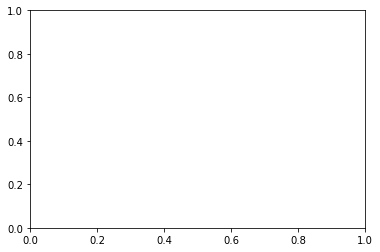

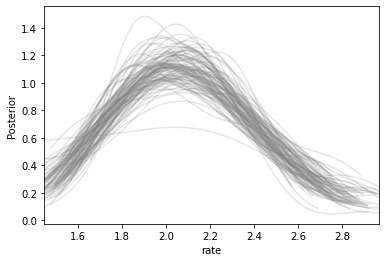

In [6]:
histories=[]
runtimes=np.zeros(iters)

for i in range(iters):
    starttime=time.time()
    
    abc = pyabc.ABCSMC(models = Model1(),
               parameter_priors = prior,
               distance_function = distance,
               population_size = pop_size,
               sampler = redis_sampler,
               eps = eps)

    abc.new(db_path, observations)
    history = abc.run(minimum_epsilon=min_eps, max_nr_populations=max_nr_pop)
    
    endtime=time.time()
    
    histories.append(history)
    runtimes[i]=endtime-starttime
    
    
tmax=histories[0].max_t
fig,ax = plt.subplots()

tmax=histories[0].max_t
fig,ax = plt.subplots()


for i in range(iters):
    df,w = histories[i].get_distribution(m=0,t=histories[i].max_t)
    pyabc.visualization.plot_kde_1d(df, w, x='rate',ax=ax, color='grey', alpha=0.2)


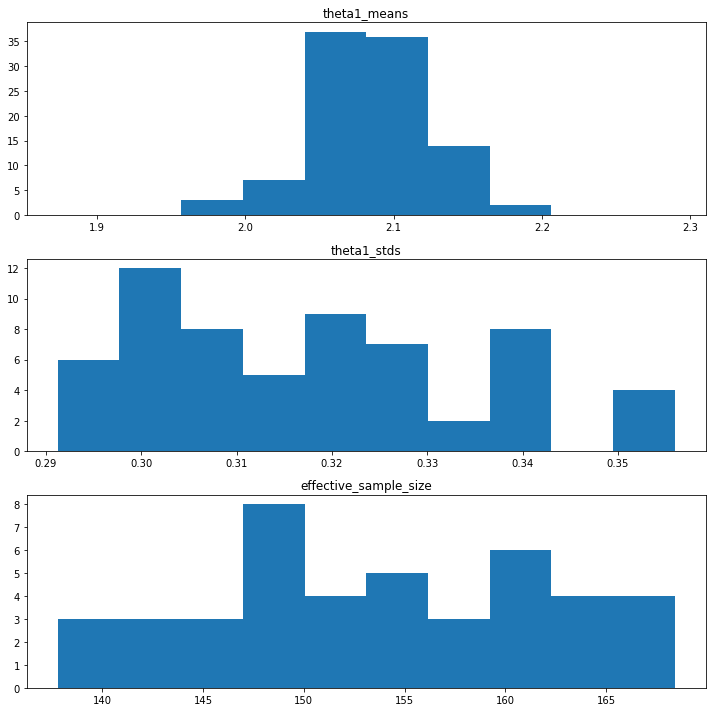

In [7]:
theta1_means = np.zeros(iters)
theta1_stds = np.zeros(iters)

theta2_means = np.zeros(iters)
theta2_stds = np.zeros(iters)

effective_sample_size=np.zeros(iters)

for i in range(iters):
    
    df,w= histories[i].get_distribution(m=0,t=histories[i].max_t)
    
    points = df['rate'].values
    theta1_means[i]=pyabc.weighted_statistics.weighted_mean(points,w)
    theta1_stds[i]=pyabc.weighted_statistics.weighted_std(points,w)
    
    effective_sample_size[i]=pyabc.weighted_statistics.effective_sample_size(w)

allnames=[]
allnames.append("theta1_means")
allnames.append("theta1_stds")
allnames.append("effective_sample_size")

alldata = []
for i in range(len(allnames)):
    alldata.append(eval(allnames[i]))
    
    
fig = plt.figure(figsize=(10,10))
nx, ny=3, 1

for i in range(3):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.hist(alldata[i], bins = 10, range=(0.9*alldata[i].mean(), 1.1*alldata[i].mean()))
    ax.set_title(allnames[i])
    
fig.tight_layout()


INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 03:07:24.418016, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 2721 = 7.3502e-02, ESS=1.9796e+02.
INFO:ABC:t: 2, eps: 5.28.
INFO:ABC:Acceptance rate: 200 / 597 = 3.3501e-01, ESS=1.9346e+02.
INFO:ABC:t: 3, eps: 2.8000000000000003.
INFO:ABC:Acceptance rate: 200 / 649 = 3.0817e-01, ESS=1.9513e+02.
INFO:ABC:t: 4, eps: 1.6800000000000002.
INFO:ABC:Acceptance rate: 200 / 1398 = 1.4306e-01, ESS=1.7836e+02.
INFO:ABC:t: 5, eps: 1.16.
INFO:ABC:Acceptance rate: 200 / 4894 = 4.0866e-02, ESS=1.2016e+02.
INFO:ABC:t: 6, eps: 0.8400000000000001.
INFO:ABC:Acceptance rate: 200 / 43528 = 4.5947e-03, ESS=1.7269e+02.
INFO:ABC:t: 7, eps: 0.6000000000000001.
INFO:ABC:Acceptance rate: 200 / 451399 = 4.4307e-04, ESS=1.0869e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 03:07:24.418016,

INFO:ABC:Acceptance rate: 200 / 128915 = 1.5514e-03, ESS=1.8092e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 03:24:18.055731, end_time=2020-11-22 03:25:52.064750)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 03:25:52.077102, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 206 = 9.7087e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 2757 = 7.2543e-02, ESS=1.9653e+02.
INFO:ABC:t: 2, eps: 5.270940160418562.
INFO:ABC:Acceptance rate: 200 / 631 = 3.1696e-01, ESS=1.9682e+02.
INFO:ABC:t: 3, eps: 2.6948751600447167.
INFO:ABC:Acceptance rate: 200 / 629 = 3.1797e-01, ESS=1.5995e+02.
INFO:ABC:t: 4, eps: 1.56.
INFO:ABC:Acceptance rate: 200 / 1626 = 1.2300e-01, ESS=1.6378e+02.
INFO:ABC:t: 5, eps: 1.07253785775233.
INFO:ABC:Acceptance rate: 200 / 6934 = 2.8843e-02, ESS=1.8402e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Acceptance rate: 200 / 60913 = 3.2834e-03, ESS=1.4126e+02.
INFO

INFO:ABC:Acceptance rate: 200 / 8631 = 2.3172e-02, ESS=1.5143e+02.
INFO:ABC:t: 6, eps: 0.7374523213562133.
INFO:ABC:Acceptance rate: 200 / 138941 = 1.4395e-03, ESS=4.9399e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 03:35:11.614079, end_time=2020-11-22 03:36:52.282876)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 03:36:52.291182, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 3775 = 5.2980e-02, ESS=1.9738e+02.
INFO:ABC:t: 2, eps: 5.169902049618634.
INFO:ABC:Acceptance rate: 200 / 764 = 2.6178e-01, ESS=1.9724e+02.
INFO:ABC:t: 3, eps: 2.5690008507266313.
INFO:ABC:Acceptance rate: 200 / 763 = 2.6212e-01, ESS=1.7901e+02.
INFO:ABC:t: 4, eps: 1.4800000000000002.
INFO:ABC:Acceptance rate: 200 / 2013 = 9.9354e-02, ESS=1.8953e+02.
INFO:ABC:t: 5, eps: 1.0.
INFO:ABC:Acceptance rate: 200 / 9696 = 2.0627e-02, ESS=1.

INFO:ABC:Acceptance rate: 200 / 1613 = 1.2399e-01, ESS=1.8589e+02.
INFO:ABC:t: 5, eps: 1.08.
INFO:ABC:Acceptance rate: 200 / 7268 = 2.7518e-02, ESS=1.6229e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Acceptance rate: 200 / 81922 = 2.4413e-03, ESS=1.5010e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 03:48:22.370218, end_time=2020-11-22 03:49:25.754078)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 03:49:25.762221, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 206 = 9.7087e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 3887 = 5.1454e-02, ESS=1.9839e+02.
INFO:ABC:t: 2, eps: 5.0.
INFO:ABC:Acceptance rate: 200 / 702 = 2.8490e-01, ESS=1.8995e+02.
INFO:ABC:t: 3, eps: 2.4800000000000004.
INFO:ABC:Acceptance rate: 200 / 715 = 2.7972e-01, ESS=1.5552e+02.
INFO:ABC:t: 4, eps: 1.4400000000000002.
INFO:ABC:Acceptance rate: 200 / 2467 = 8.1070e-02, ESS=1.7388e+02.
INFO:ABC:t: 5, eps

INFO:ABC:Acceptance rate: 200 / 807 = 2.4783e-01, ESS=1.9098e+02.
INFO:ABC:t: 4, eps: 1.4400000000000002.
INFO:ABC:Acceptance rate: 200 / 2200 = 9.0909e-02, ESS=1.5063e+02.
INFO:ABC:t: 5, eps: 0.96.
INFO:ABC:Acceptance rate: 200 / 13527 = 1.4785e-02, ESS=1.6115e+02.
INFO:ABC:t: 6, eps: 0.7200000000000001.
INFO:ABC:Acceptance rate: 200 / 138017 = 1.4491e-03, ESS=1.6618e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 04:00:44.529957, end_time=2020-11-22 04:02:27.968568)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 04:02:27.977817, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 206 = 9.7087e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 5375 = 3.7209e-02, ESS=1.9675e+02.
INFO:ABC:t: 2, eps: 5.120000000000001.
INFO:ABC:Acceptance rate: 200 / 582 = 3.4364e-01, ESS=1.9782e+02.
INFO:ABC:t: 3, eps: 2.6267374592503594.
INFO:ABC:Acceptance rate: 200 / 644 = 3.1056e-01, ESS=1

INFO:ABC:t: 2, eps: 4.960000000000001.
INFO:ABC:Acceptance rate: 200 / 596 = 3.3557e-01, ESS=1.9272e+02.
INFO:ABC:t: 3, eps: 2.342493717402307.
INFO:ABC:Acceptance rate: 200 / 893 = 2.2396e-01, ESS=1.9701e+02.
INFO:ABC:t: 4, eps: 1.4400000000000002.
INFO:ABC:Acceptance rate: 200 / 2025 = 9.8765e-02, ESS=1.4090e+02.
INFO:ABC:t: 5, eps: 1.0.
INFO:ABC:Acceptance rate: 200 / 9779 = 2.0452e-02, ESS=1.7080e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Acceptance rate: 200 / 74131 = 2.6979e-03, ESS=1.7749e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 04:12:57.969962, end_time=2020-11-22 04:13:58.780189)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 04:13:58.789426, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 3545 = 5.6417e-02, ESS=1.9703e+02.
INFO:ABC:t: 2, eps: 4.88.
INFO:ABC:Acceptance rate: 200 / 745 = 2.6846e-0

INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 4691 = 4.2635e-02, ESS=1.9638e+02.
INFO:ABC:t: 2, eps: 4.960000000000001.
INFO:ABC:Acceptance rate: 200 / 597 = 3.3501e-01, ESS=1.9781e+02.
INFO:ABC:t: 3, eps: 2.5600000000000005.
INFO:ABC:Acceptance rate: 200 / 727 = 2.7510e-01, ESS=1.8981e+02.
INFO:ABC:t: 4, eps: 1.4800000000000002.
INFO:ABC:Acceptance rate: 200 / 1744 = 1.1468e-01, ESS=1.7256e+02.
INFO:ABC:t: 5, eps: 1.0.
INFO:ABC:Acceptance rate: 200 / 9283 = 2.1545e-02, ESS=1.2950e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Acceptance rate: 200 / 74702 = 2.6773e-03, ESS=1.7443e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 04:25:31.452167, end_time=2020-11-22 04:26:32.555353)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 04:26:32.564422, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 205 = 9.7561e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 3203 = 6.2441e

INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 04:39:18.885519, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 206 = 9.7087e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 4068 = 4.9164e-02, ESS=1.9776e+02.
INFO:ABC:t: 2, eps: 5.03703509298399.
INFO:ABC:Acceptance rate: 200 / 744 = 2.6882e-01, ESS=1.9558e+02.
INFO:ABC:t: 3, eps: 2.4000000000000004.
INFO:ABC:Acceptance rate: 200 / 735 = 2.7211e-01, ESS=1.8919e+02.
INFO:ABC:t: 4, eps: 1.4400000000000002.
INFO:ABC:Acceptance rate: 200 / 2335 = 8.5653e-02, ESS=1.4087e+02.
INFO:ABC:t: 5, eps: 0.96.
INFO:ABC:Acceptance rate: 200 / 14514 = 1.3780e-02, ESS=1.5693e+02.
INFO:ABC:t: 6, eps: 0.7200000000000001.
INFO:ABC:Acceptance rate: 200 / 117295 = 1.7051e-03, ESS=1.7857e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 04:39:18.885519, end_time=2020-11-22 04:40:50.337211)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 0

INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 04:52:10.787674, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 4240 = 4.7170e-02, ESS=1.9584e+02.
INFO:ABC:t: 2, eps: 4.960000000000001.
INFO:ABC:Acceptance rate: 200 / 682 = 2.9326e-01, ESS=1.9260e+02.
INFO:ABC:t: 3, eps: 2.4800000000000004.
INFO:ABC:Acceptance rate: 200 / 712 = 2.8090e-01, ESS=1.8897e+02.
INFO:ABC:t: 4, eps: 1.56.
INFO:ABC:Acceptance rate: 200 / 1683 = 1.1884e-01, ESS=1.7044e+02.
INFO:ABC:t: 5, eps: 1.08.
INFO:ABC:Acceptance rate: 200 / 6428 = 3.1114e-02, ESS=1.5973e+02.
INFO:ABC:t: 6, eps: 0.8.
INFO:ABC:Acceptance rate: 200 / 46033 = 4.3447e-03, ESS=1.8185e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 04:52:10.787674, end_time=2020-11-22 04:52:51.919600)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 04:52:51.933342, end_time=None)

INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 05:04:05.508922, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 206 = 9.7087e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 3228 = 6.1958e-02, ESS=1.9667e+02.
INFO:ABC:t: 2, eps: 5.04.
INFO:ABC:Acceptance rate: 200 / 643 = 3.1104e-01, ESS=1.9512e+02.
INFO:ABC:t: 3, eps: 2.4000000000000004.
INFO:ABC:Acceptance rate: 200 / 712 = 2.8090e-01, ESS=1.9407e+02.
INFO:ABC:t: 4, eps: 1.4800000000000002.
INFO:ABC:Acceptance rate: 200 / 1855 = 1.0782e-01, ESS=1.7641e+02.
INFO:ABC:t: 5, eps: 1.04.
INFO:ABC:Acceptance rate: 200 / 9668 = 2.0687e-02, ESS=1.4975e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Acceptance rate: 200 / 72128 = 2.7728e-03, ESS=1.1071e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 05:04:05.508922, end_time=2020-11-22 05:05:04.500065)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 05:05:04.516125, end_time=Non

INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 05:16:31.878948, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 3301 = 6.0588e-02, ESS=1.9734e+02.
INFO:ABC:t: 2, eps: 5.120000000000001.
INFO:ABC:Acceptance rate: 200 / 698 = 2.8653e-01, ESS=1.9511e+02.
INFO:ABC:t: 3, eps: 2.6469906431759704.
INFO:ABC:Acceptance rate: 200 / 762 = 2.6247e-01, ESS=1.8632e+02.
INFO:ABC:t: 4, eps: 1.56.
INFO:ABC:Acceptance rate: 200 / 1698 = 1.1779e-01, ESS=1.7418e+02.
INFO:ABC:t: 5, eps: 1.08.
INFO:ABC:Acceptance rate: 200 / 7501 = 2.6663e-02, ESS=1.7653e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Acceptance rate: 200 / 80710 = 2.4780e-03, ESS=1.7621e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 05:16:31.878948, end_time=2020-11-22 05:17:34.911545)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 05:17:34.926979, end_time=None

INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 05:26:16.602986, end_time=None)>
INFO:ABC:t: 0, eps: 500.
INFO:ABC:Acceptance rate: 200 / 207 = 9.6618e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 8.32.
INFO:ABC:Acceptance rate: 200 / 3332 = 6.0024e-02, ESS=1.9858e+02.
INFO:ABC:t: 2, eps: 5.247816864042802.
INFO:ABC:Acceptance rate: 200 / 671 = 2.9806e-01, ESS=1.7957e+02.
INFO:ABC:t: 3, eps: 2.578171991065423.
INFO:ABC:Acceptance rate: 200 / 790 = 2.5316e-01, ESS=1.9741e+02.
INFO:ABC:t: 4, eps: 1.4800000000000002.
INFO:ABC:Acceptance rate: 200 / 2101 = 9.5193e-02, ESS=1.3647e+02.
INFO:ABC:t: 5, eps: 1.0.
INFO:ABC:Acceptance rate: 200 / 10423 = 1.9188e-02, ESS=1.6904e+02.
INFO:ABC:t: 6, eps: 0.76.
INFO:ABC:Acceptance rate: 200 / 65890 = 3.0354e-03, ESS=1.5838e+02.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-11-22 05:26:16.602986, end_time=2020-11-22 05:27:12.465550)>
INFO:History:Start <ABCSMC(id=1, start_time=2020-11-22 05:27:12.474883, 

KeyError: "None of [Index(['rate'], dtype='object', name='name')] are in the [columns]"

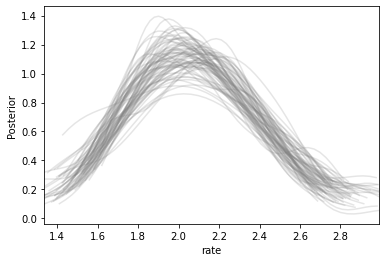

In [8]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost",
                                                       port=6379,
                                                       look_ahead = False)

histories_ori=[]
runtimes_ori=np.zeros(iters)

for i in range(iters):
    starttime=time.time()
    
    abc = pyabc.ABCSMC(models = Model1(),
               parameter_priors = prior,
               distance_function = distance,
               population_size = pop_size,
               sampler = redis_sampler,
               eps = eps)

    abc.new(db_path, observations)
    history = abc.run(minimum_epsilon=min_eps, max_nr_populations=max_nr_pop)
    
    endtime=time.time()
    
    histories_ori.append(history)
    runtimes_ori[i]=endtime-starttime
    
    
fig,ax = plt.subplots()


for i in range(iters):
    df,w = histories_ori[i].get_distribution(m=0,t=histories_ori[i].max_t)
    pyabc.visualization.plot_kde_1d(df, w, x='rate',ax=ax, color='grey', alpha=0.2)


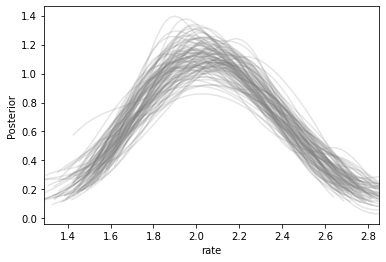

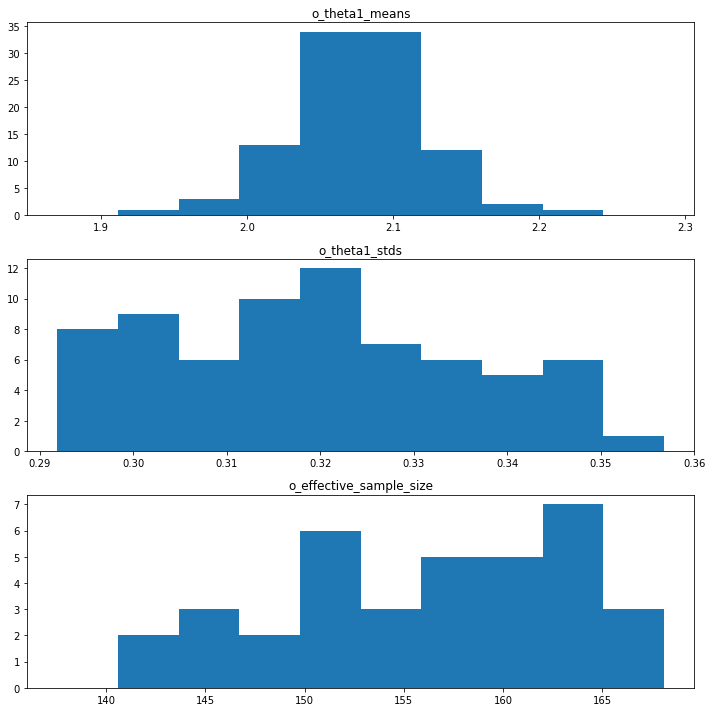

In [12]:
o_theta1_means = np.zeros(iters)
o_theta1_stds = np.zeros(iters)

o_effective_sample_size = np.zeros(iters)

for i in range(iters):
    
    df,w= histories_ori[i].get_distribution(m=0,t=histories_ori[i].max_t)
    
    points = df['rate'].values
    o_theta1_means[i]=pyabc.weighted_statistics.weighted_mean(points,w)
    o_theta1_stds[i]=pyabc.weighted_statistics.weighted_std(points,w)
    
    o_effective_sample_size[i]=pyabc.weighted_statistics.effective_sample_size(w)

allnames_ori=[]
allnames_ori.append("o_theta1_means")
allnames_ori.append("o_theta1_stds")
allnames_ori.append("o_effective_sample_size")

alldata_ori = []
for i in range(len(allnames_ori)):
    alldata_ori.append(eval(allnames_ori[i]))
    
fig = plt.figure(figsize=(10,10))
nx, ny=3, 1

for i in range(3):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.hist(alldata_ori[i], bins = 10, range=(0.9*alldata_ori[i].mean(), 1.1*alldata_ori[i].mean()))
    ax.set_title(allnames_ori[i])
    
fig.tight_layout()


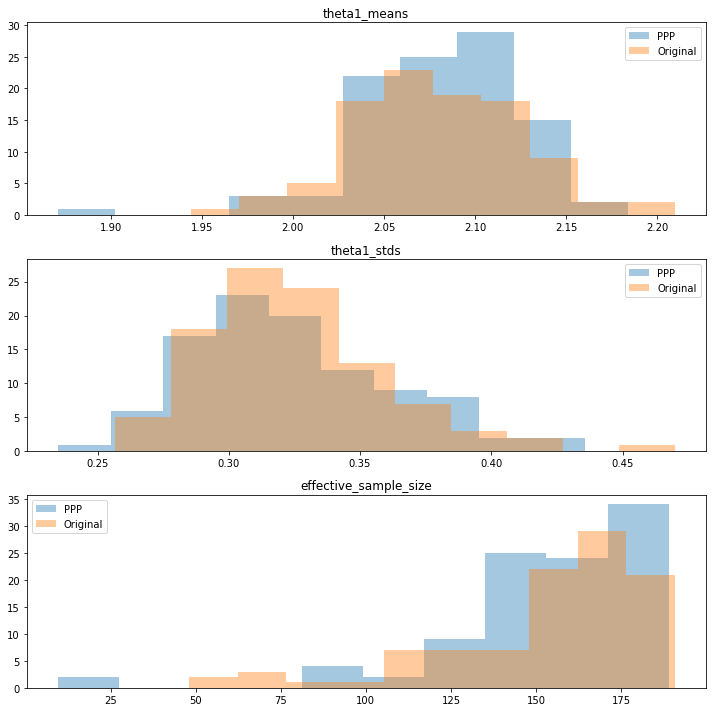

In [14]:
import seaborn as sns

fig = plt.figure(figsize=(10,10))
nx, ny=3, 1

for i in range(3):
    ax = fig.add_subplot(nx,ny,i+1)
    ax.set_title(allnames[i])

    bins=10
    sns.distplot(alldata[i], ax = ax, bins = bins, kde=False, label="PPP")
    sns.distplot(alldata_ori[i], ax = ax, bins = bins, kde=False, label="Original")
    ax.legend()
    
fig.tight_layout()


plt.savefig("/home/felipe/MTGraphics/MJPResultComp.jpg")